# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping


## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [3]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
100% 235k/235k [00:00<00:00, 604kB/s]
100% 235k/235k [00:00<00:00, 603kB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [4]:
df = pd.read_csv("/content/Traffic Data.csv")
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

### Plot the time series data.

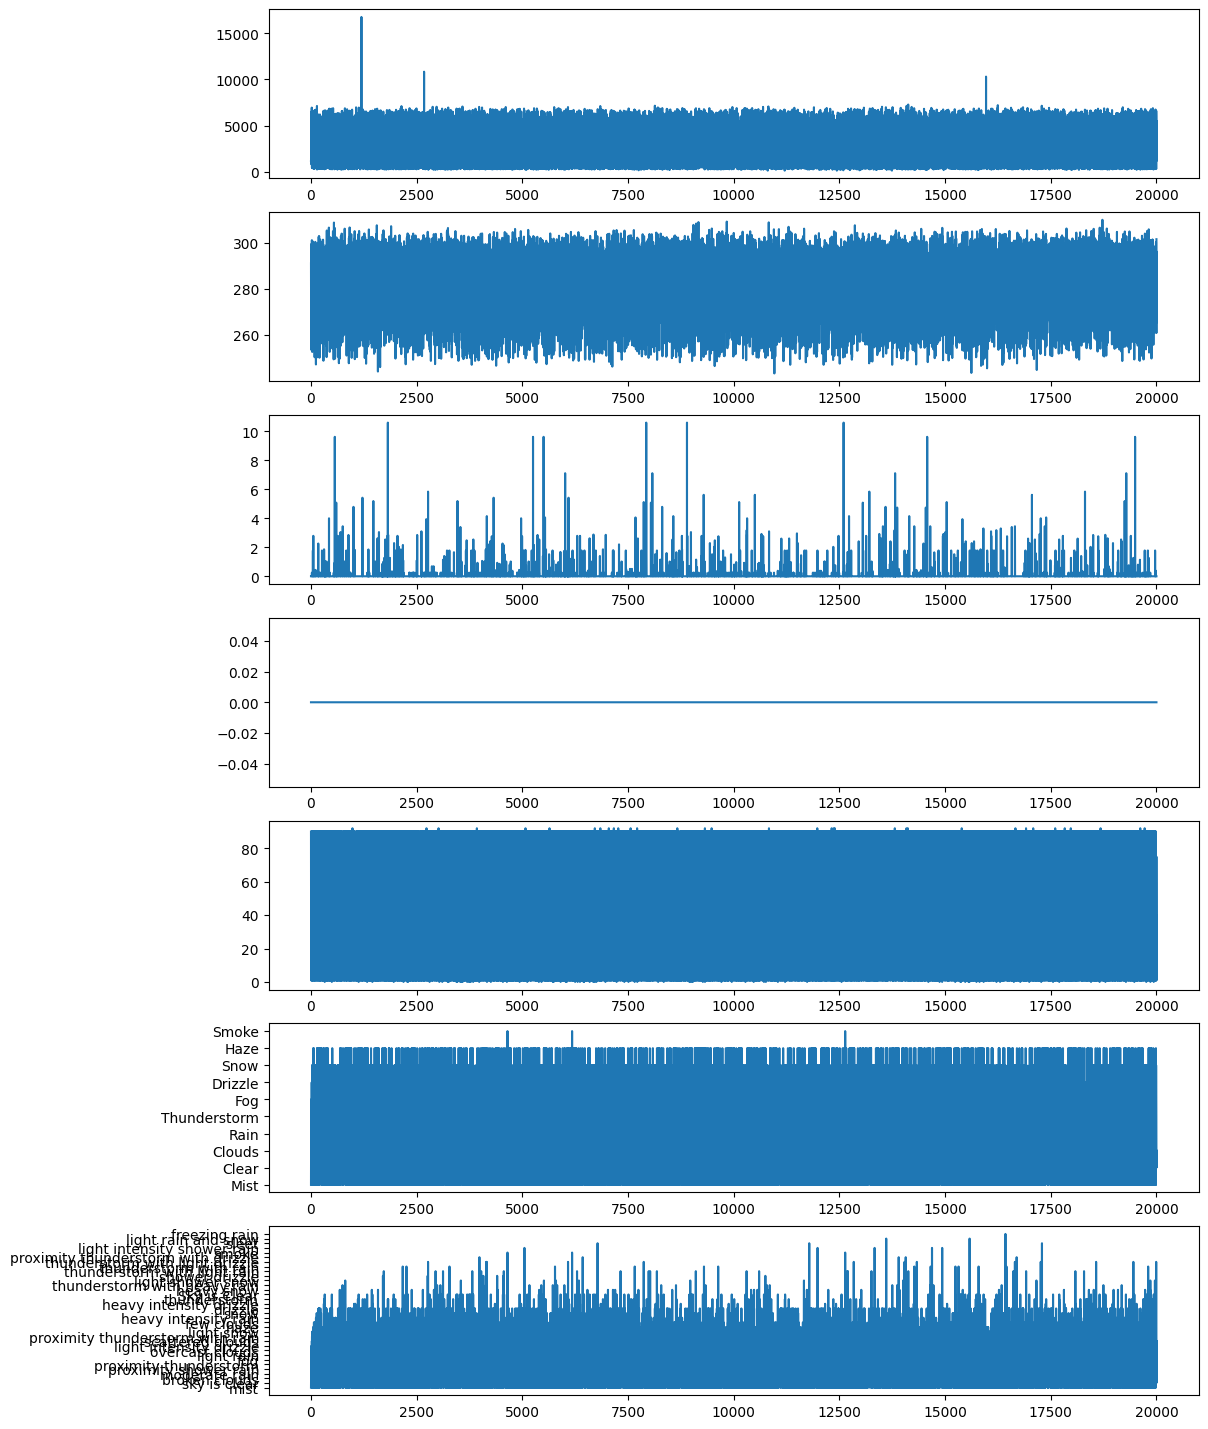

In [5]:
_, ax = plt.subplots(nrows=7, ncols=1, figsize=(12, 18))

for i, col in enumerate(df.drop(columns=["date_time"]).columns):
  ax[i].plot(df[col])

### Box plot to identify any outliers or anomalies in the data.

In [16]:
columns = df.select_dtypes(include=["float", "int"]).columns.tolist()
columns

['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all']

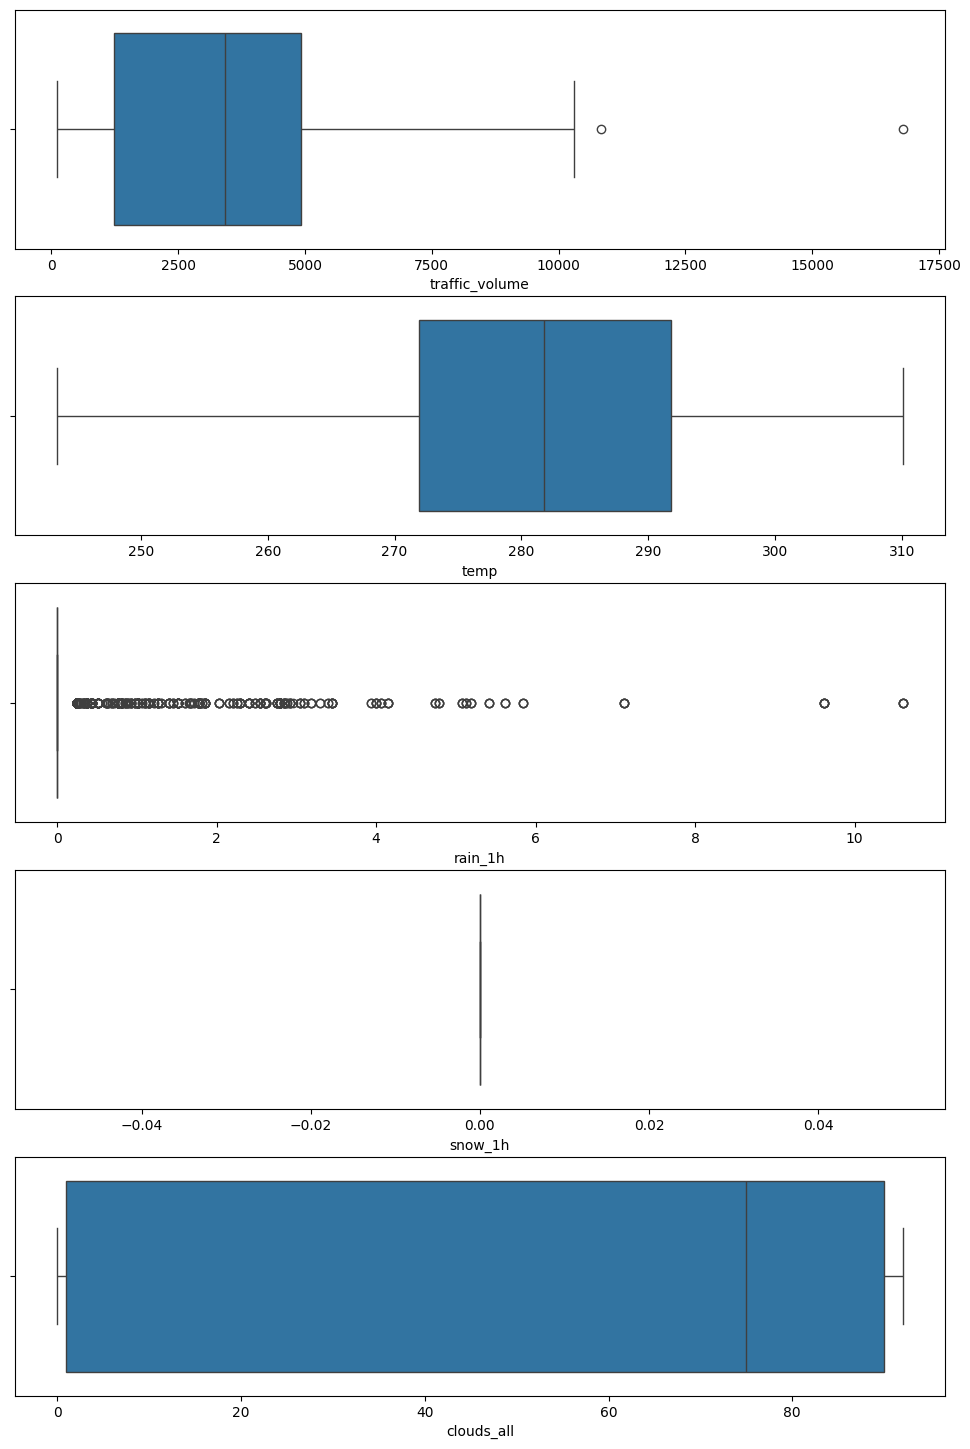

In [24]:
_, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 18))

for i, col in enumerate(columns):
  sns.boxplot(x=df[col], ax=ax[i])




### Seasonal Decomposition

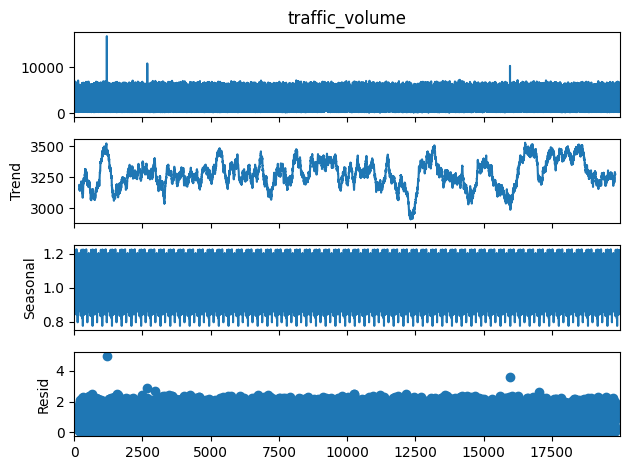

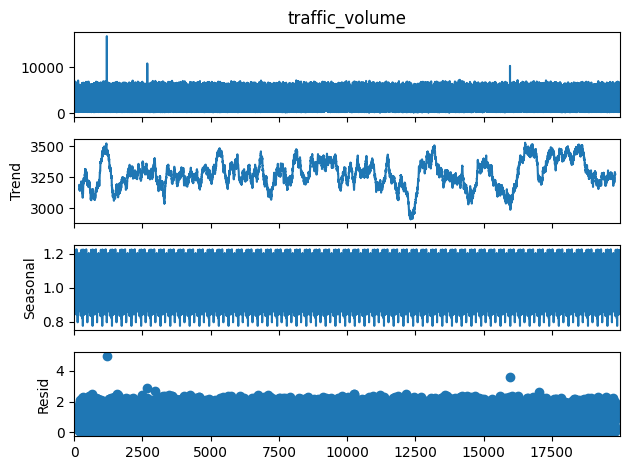

In [9]:
result = seasonal_decompose(df["traffic_volume"].ffill(), model="multiplicative", period=356)

result.plot()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [ ]:
df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [ ]:
# _, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 18))
# # 1) FILL WITH 0
# ax[0]= plt.plot(df["date_time"], df["traffic_volume"].fillna(0), color="orange", label="modified")
# # ax[0]= plt.plot(df["date_time"], df["traffic_volume"], color="blue", label="original")


### Fill missing values using `ffill`

In [ ]:
# Rows that contain nan value
df[df.isnull().any(axis=1)]

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,prev_traffic_volume


In [ ]:
df["traffic_volume"] = df["traffic_volume"].ffill()

In [ ]:
# Ensuring the rows have been filled
df.isnull().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


### Drop duplicates

In [ ]:
df.duplicated().sum()

0

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

0

### Change type and sort `date_time` column

In [29]:
df["date_time"] = pd.to_datetime(df["date_time"])
df = df.sort_values(by=["date_time"])

df.head(10)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,prev_traffic_volume,diff_1_traffic_volume
7745,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,2016-11-18 15:00:00,3403.0,1469.0
4628,4872.0,274.08,0.0,0.0,90,Fog,fog,2016-11-18 15:00:00,3253.0,1619.0
14496,4872.0,274.08,0.0,0.0,90,Mist,mist,2016-11-18 15:00:00,6038.0,-1166.0
8867,5074.0,273.84,0.0,0.0,90,Fog,fog,2016-11-18 16:00:00,2453.0,2621.0
3867,5074.0,273.84,0.0,0.0,90,Mist,mist,2016-11-18 16:00:00,3071.0,2003.0
18985,5074.0,273.84,0.0,0.0,90,Snow,heavy snow,2016-11-18 16:00:00,775.0,4299.0
14066,4328.0,273.62,0.0,0.0,90,Snow,heavy snow,2016-11-18 17:00:00,234.0,4094.0
6235,4328.0,273.62,0.0,0.0,90,Mist,mist,2016-11-18 17:00:00,4570.0,-242.0
8329,4328.0,273.62,0.0,0.0,90,Fog,fog,2016-11-18 17:00:00,4879.0,-551.0
2646,3486.0,273.59,0.0,0.0,90,Snow,heavy snow,2016-11-18 18:00:00,4689.0,-1203.0


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 7745 to 3795
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       20000 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  object        
 6   weather_description  20000 non-null  object        
 7   date_time            20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.4+ MB


### Shift method

In [25]:

df["prev_traffic_volume"] = df["traffic_volume"].shift(1)

# Fill "prev_traffic_volume" for first row with the first row of "traffic_volume"
df["prev_traffic_volume"] = df["prev_traffic_volume"].fillna(df["traffic_volume"].tolist()[0])

df[["traffic_volume", "prev_traffic_volume"]]

,traffic_volume,prev_traffic_volume
0,1209.0,1209.0
1,1248.0,1209.0
2,4602.0,1248.0
3,2838.0,4602.0
4,5794.0,2838.0
...,...,...
19995,2723.0,6601.0
19996,5895.0,2723.0
19997,1132.0,5895.0
19998,5525.0,1132.0


### Difference between `traffic_volume`

In [27]:
df["diff_1_traffic_volume"] = df["traffic_volume"].diff()

# Fill "prev_traffic_volume" for first row with the first row of "traffic_volume"
df["diff_1_traffic_volume"] = df["diff_1_traffic_volume"].fillna(df["traffic_volume"].tolist()[0])


df[["traffic_volume", "diff_1_traffic_volume"]]

,traffic_volume,diff_1_traffic_volume
0,1209.0,1209.0
1,1248.0,39.0
2,4602.0,3354.0
3,2838.0,-1764.0
4,5794.0,2956.0
...,...,...
19995,2723.0,-3878.0
19996,5895.0,3172.0
19997,1132.0,-4763.0
19998,5525.0,4393.0


### Data features

In [32]:
# Day of the week: To capture weekly seasonality.
# Month: To capture monthly trends.
# Day of the year: Useful for modeling yearly seasonality.

df["week_day"] = df["date_time"].dt.dayofweek
df["month"] = df["date_time"].dt.month
df["year_day"] = df["date_time"].dt.dayofyear

df.sample(5)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,prev_traffic_volume,diff_1_traffic_volume,week_day,month,year_day
13667,4847.0,292.36,0.0,0.0,40,Clouds,scattered clouds,2018-09-22 17:00:00,3168.0,1679.0,5,9,265
3915,2901.0,284.23,0.0,0.0,40,Clouds,scattered clouds,2017-10-11 20:00:00,3626.0,-725.0,2,10,284
9318,851.0,272.13,0.0,0.0,92,Clouds,overcast clouds,2018-03-26 04:00:00,1501.0,-650.0,0,3,85
13092,2451.0,264.96,0.0,0.0,5,Clear,sky is clear,2018-03-07 21:00:00,4933.0,-2482.0,2,3,66
3001,5582.0,269.88,0.0,0.0,90,Clouds,overcast clouds,2016-12-30 14:00:00,3319.0,2263.0,4,12,365


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [ ]:
new_df = df[["traffic_volume"]]


train_size = int(len(new_df) * 0.8)

train_data = new_df[:train_size].values.astype("float32")
test_data = new_df[train_size:].values.astype("float32")

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

Train size: 15990
Test size: 3998


## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [ ]:
new_df

,traffic_volume
7745,4872.0
4628,4872.0
14496,4872.0
8867,5074.0
3867,5074.0
...,...
6605,3543.0
14241,2781.0
9500,2159.0
15201,1450.0


In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)


In [ ]:
def create_dataset(dataset, steps):
    X, Y = [], []
    for i in range(len(dataset) - steps - 1):
        a = dataset[i:(i + steps), 0:dataset.shape[1]]
        X.append(a)
        Y.append(dataset[i + steps, 0])
    return np.array(X), np.array(Y)
steps_back = 50
X_train, y_train = create_dataset(train_data_scaled, steps_back)
X_test, y_test = create_dataset(test_data_scaled, steps_back)

In [ ]:

print(f"X_train.shape: {X_train.shape}")
print("---------------------------------")
print(f"X_test.shape: {X_test.shape}")



X_train.shape: (15939, 50, 1)
---------------------------------
X_test.shape: (3947, 50, 1)


## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [ ]:
X_train.shape

(15939, 50, 1)

In [ ]:
model_lstm = Sequential()

model_lstm.add(layers.LSTM(units = 20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(layers.LSTM(units = 20, return_sequences=False))
model_lstm.add(layers.Dropout(0.2))
model_lstm.add(layers.BatchNormalization())
model_lstm.add(layers.Dense(1))

callbacks = [
    EarlyStopping("val_loss", patience=10)
]

model_lstm.compile(
    optimizer="adam",
    loss="mean_squared_error",
)

model_lstm.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 50, 20)              │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,141 (20.08 KB)

 Trainable params: 5,101 (19.93 KB)

 Non-trainable params: 40 (160.00 B)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [ ]:
history = model_lstm.fit(X_train, y_train, epochs=20,
               validation_split=0.2, batch_size=16,
               callbacks = callbacks
               )

Epoch 1/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - loss: 0.0255 - val_loss: 0.0056
Epoch 2/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 3/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 4/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 54s 53ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 5/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 73s 43ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 6/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 7/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 8/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 9/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 10/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 11/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 12/20
797/797 ━━━━━━━━━━

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [ ]:
pred_lstm = model_lstm.predict(X_test)

124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss. **(I did this step for GRU model (Model 2). I couldn't store the `history` value at the beginning and to store again I need to retrain the model again, which will take time)**

In [ ]:
# Calculate MSE and RMSE.
mse_lstm = mean_squared_error(y_test, pred_lstm)

# "squared=False" to get "RMSE"
rmse_lstm = mean_squared_error(y_test, pred_lstm, squared=False)

print(f"MSE SCORE: {mse_lstm}")
print(f"RMSE SCORE: {rmse_lstm}")


MSE SCORE: 0.0014203260652720928
RMSE SCORE: 0.037687212228775024


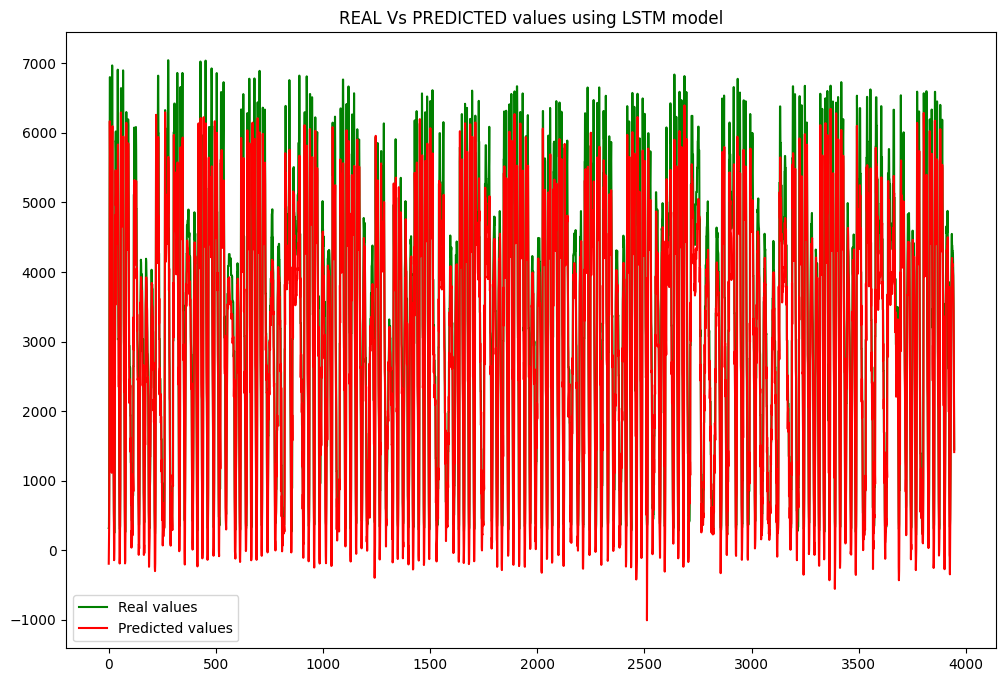

In [ ]:
# Plot the predicted vs actual values for the test set.

test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
pred_lstm_inv_tra = scaler.inverse_transform(pred_lstm)

plt.figure(figsize=(12, 8))
plt.plot(test_true, color="green", label="Real values")
plt.plot(pred_lstm_inv_tra, color="red", label="Predicted values")
plt.title("REAL Vs PREDICTED values using LSTM model")
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [ ]:
model_gru = Sequential()

model_gru.add(layers.GRU(units = 20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(layers.GRU(units = 20, return_sequences=False))
model_gru.add(layers.Dropout(0.5))
model_gru.add(layers.Dense(1))


callbacks = [
    EarlyStopping("val_loss", patience=10)
]

model_gru.compile(
    optimizer="adam",
    loss="mean_squared_error",
)

model_gru.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50, 20)              │           1,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 20)                  │           2,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,921 (15.32 KB)

 Trainable params: 3,921 (15.32 KB)

 Non-trainable params: 0 (0.00 B)

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [ ]:
history = model_gru.fit(X_train, y_train, epochs=20,
               validation_split=0.2, batch_size=16,
               callbacks = callbacks
               )


Epoch 1/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 53s 61ms/step - loss: 0.0078 - val_loss: 0.0021
Epoch 2/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 75s 52ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 3/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 79s 49ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 4/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 5/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 6/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 87s 63ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 7/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 70s 48ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 43s 50ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 9/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 10/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 11/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 12/20
797/797 ━━━━━━━━━━

In [ ]:
pred_gru = model_gru.predict(X_test)


124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [ ]:
# Calculate MSE and RMSE.
mse_gru = mean_squared_error(y_test, pred_gru)

# "squared=False" to get "RMSE"
rmse_gru = mean_squared_error(y_test, pred_gru, squared=False)

print(f"MSE SCORE: {mse_gru}")
print(f"RMSE SCORE: {rmse_gru}")




MSE SCORE: 0.0009403088479302824
RMSE SCORE: 0.030664455145597458


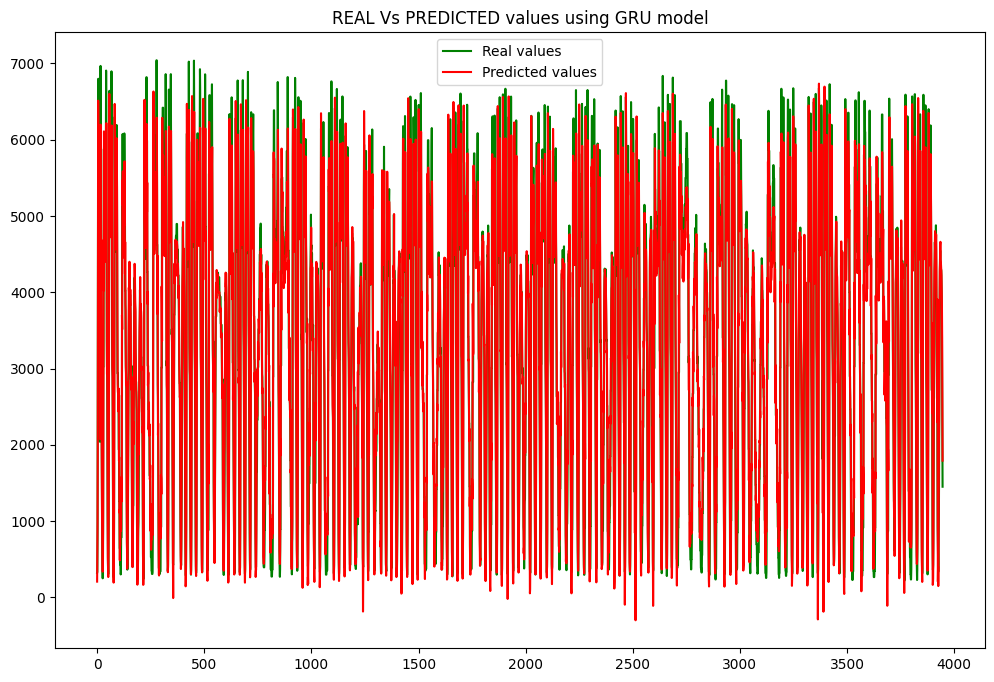

In [ ]:
# Plot the predicted vs actual values for the test set.

test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
pred_gru_inv_tra = scaler.inverse_transform(pred_gru)

plt.figure(figsize=(12, 8))
plt.plot(test_true, color="green", label="Real values")
plt.plot(pred_gru_inv_tra, color="red", label="Predicted values")
plt.title("REAL Vs PREDICTED values using GRU model")
plt.legend()
plt.show()

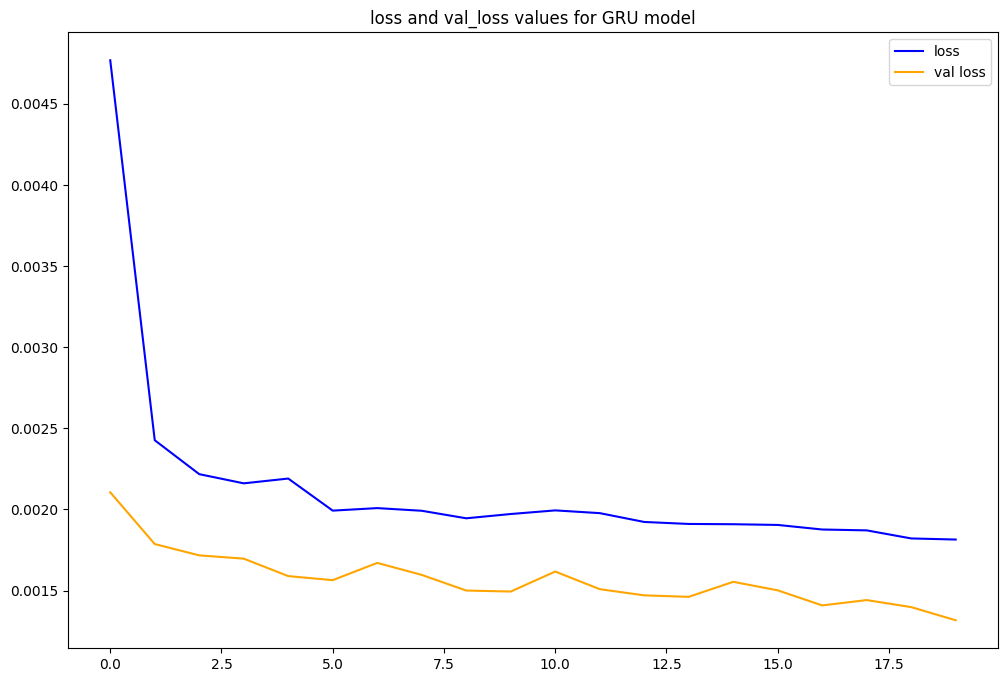

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(12, 8))
plt.plot(loss, color="blue", label="loss")
plt.plot(val_loss, color="orange", label="val loss")
plt.title("loss and val_loss values for GRU model")
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

**1. Data Preprocessing**

- Before we train our model, we need to preprocess the data so we can train the model. First thing I did was checking whether the dataset contains any missing or duplicate values.I found out there were missing and duplicate values. **I dropped the duplicate values** and **filled missing values using `ffill` technique** .And then **normalized the dataset using `MinMaxScaler`**

**2. Feature Engineering**

- About feature engineering, I created new features using different techniques such as **shift** and **differencing** methods. Not only that, but also I created **day of: week, month, and year.**

**3. Model Architecture**

- I used **LSTM** and **GRU** models because they are good for time series dataset. I structured both models with same number of nuerons and similar layers. But the structure for **LSTM** is a bit different. I added `BatchNormalization` to avoid the model from being prone to overfitting. But both have `Dropout` layer ensuring to avoid overfitting

**4. Training Process**

- I chose a small number for **epochs** and **batch_size** since higher numbers take time to finish. But the result from both models consider good.


**5. Loss Function and Metrics (MSE and RMSE)**
  
  - But the **MSE** and **RMSE** results from both models are small, which indicate a good result

  - **LSTM:**
    - MSE SCORE: 0.00142
    - RMSE SCORE: 0.0376

  - **GRU:**
    - MSE SCORE: 0.00094
    - RMSE SCORE: 0.0306

**7. Overfitting and Underfitting**

- To whether know if the model suffers from overfitting or underfitting, an easy way is to see the result of **loss** and **val_loss**. I plotted the results, and from what I saw, there were neither overfitting nor underfitting. This means the models are robust and accurate at predicting unseen data.

**8. Future Improvements**

- Things can be improved by adding extra layers and regularization techniques at the same time to avoid overfitting.

- Since I have a fixed time, I could not experiment with different values to see whether the model has improved or not. So experimenting with different values can make the model perform better.